In [1]:
%load_ext autoreload
%autoreload 2

# 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [78]:
N = 12

x = np.random.random( 2*(N+1) )
y = np.random.random( 2*(N+1) )

a = np.random.random( 2*(N+1) )
b = np.random.random( 2*(N+1) )

print(x); print(y)
print(a); print(b)

[0.57521723 0.9900447  0.36901113 0.50141493 0.77719815 0.63169452
 0.33310397 0.18645573 0.03903122 0.24054079 0.80782783 0.86473097
 0.91344636 0.33141113 0.33513278 0.08010906 0.01253247 0.98026266
 0.54378641 0.54939509 0.4086673  0.11005273 0.02268645 0.70915544
 0.97761495 0.08496927]
[0.08611365 0.38760829 0.77020566 0.05330512 0.12719753 0.70355202
 0.55292859 0.75502966 0.48468576 0.32079717 0.57672535 0.86338661
 0.17091017 0.44149881 0.18758481 0.11624223 0.33815942 0.39954396
 0.8422478  0.60239118 0.88855832 0.55433168 0.63433162 0.76361476
 0.48751289 0.13735348]
[0.99766648 0.31871506 0.11208689 0.36176885 0.06407515 0.50298335
 0.26711395 0.48674716 0.73948463 0.94120722 0.50740416 0.16985181
 0.56957686 0.48007539 0.88673393 0.09149092 0.66916327 0.52993289
 0.37797511 0.31961111 0.89737483 0.40142107 0.78680361 0.65011191
 0.23538228 0.9483497 ]
[0.09354725 0.87914097 0.83529935 0.30722698 0.78760241 0.05397362
 0.28071174 0.82952974 0.62899715 0.41731676 0.27016415 0

In [36]:
state_action = [f"({i}, 0)" for i in range(N+1)] + [f"({i}, 1)" for i in range(N+1)]

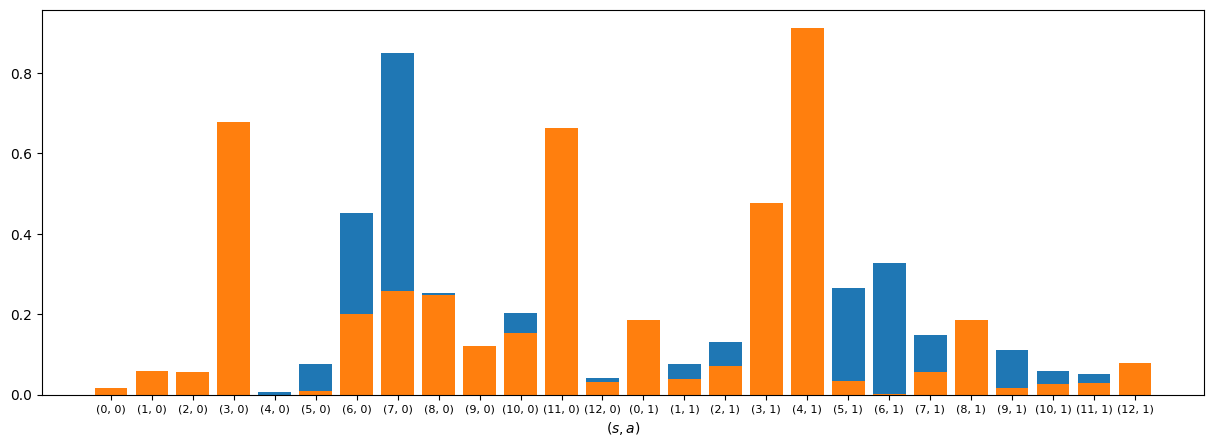

In [53]:
plt.figure( figsize=(15, 5), )

plt.bar(state_action, (x - y) ** 2)
plt.bar(state_action, (a - b) ** 2)

plt.xticks(fontsize=8)

plt.xlabel(r"$(s, a)$")
plt.ylabel(r"")
plt.show()


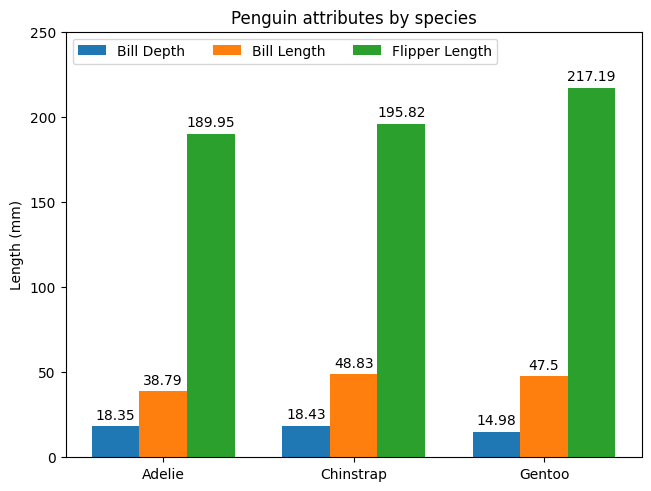

In [88]:
def group_barplot(group_names, grouped_values, title=None, ylabel=None, ylim=None, bar_width=0.25, bar_labels=False, legend_loc=None, figsize=None):
    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

    _, ax = plt.subplots( layout="constrained", figsize=figsize, )

    x = np.arange( len(group_names) )

    multiplier = 0
    for attribute, measurement in grouped_values.items():
        offset = bar_width * multiplier
        rects = ax.bar(x + offset, measurement, bar_width, label=attribute)
        if bar_labels: ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.set_xticks(x + bar_width, group_names)
    ax.legend(loc=legend_loc, ncols=3)

    if title  is not None: ax.set_title(title)
    if ylabel is not None: ax.set_ylabel(ylabel)
    if ylim   is not None: ax.set_ylim(ylim)

    plt.show()

group_barplot(
    group_names=("Adelie", "Chinstrap", "Gentoo"),
    grouped_values = {
        "Bill Depth": (18.35, 18.43, 14.98),
        "Bill Length": (38.79, 48.83, 47.50),
        "Flipper Length": (189.95, 195.82, 217.19),
    },
    title="Penguin attributes by species",
    ylabel="Length (mm)",
    ylim=(0, 250),
    bar_width=0.25,
    bar_labels=True,
    legend_loc="upper left",
)

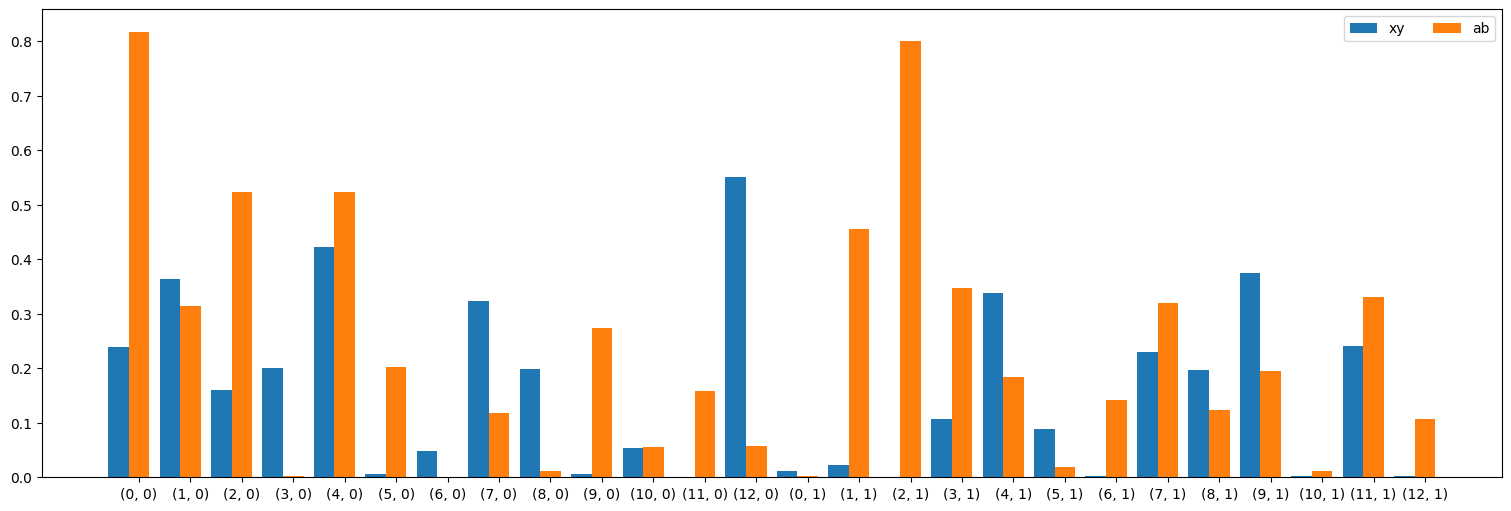

In [92]:
group_barplot(
    group_names=state_action,
    grouped_values={ "xy": (x-y)**2, "ab": (a-b)**2, },
    figsize=(15, 5),
    bar_width=0.4,
)

# 2

In [96]:
n_approximate_solutions = 10
approximate_solutions = []

for i in range(80):
    approximate_solutions.append(i)
    if len(approximate_solutions) > n_approximate_solutions:
        approximate_solutions.pop(0)

approximate_solutions

[70, 71, 72, 73, 74, 75, 76, 77, 78, 79]

# 3

In [1]:
import os

In [10]:
def rename_recursively(directory, name_old, name_new, kind):
    for root, dirs, files in os.walk(directory):
        names = []
        if kind == "dirs":  names = dirs
        if kind == "files": names = files

        for name in names:
            if name_old in name:
                replaced = name.replace(name_old, name_new)
                path_old = os.path.join(root, name)
                path_new = os.path.join(root, replaced)
                os.rename(path_old, path_new)

In [13]:
rename_recursively(
    os.path.join("data", "boyan_chain", "outputs"),
    r"TabularGradientDice $\lambda$ = ",
    r"TabularGradientDice_lam=",
    kind="dirs",
)

# 4

In [6]:
import numpy as np

from gymnasium import Env
from gymnasium.spaces import Discrete

from typing import Any, SupportsFloat

from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker

In [7]:
class RecyclingRobot(Env):
    """
    Sutton & Barto "Recycling Robot" page 52
    observation_space:
        low: 0
        high: 1
    action_space:
        wait: 0
        search: 1
        recharge: 2
    """

    def __init__(self, time_step_max, alpha, beta, r_wait, r_search_low, r_search_high):
        """
        Args:
            time_step_max: once reached, step outputs `done = True`
            alpha: probability of staying high when searching high
            beta:  probability of staying low when searching low
            r_wait: reward (function) when waiting
            r_search_low: reward (function) when searching low
            r_search_high: reward (function) when searching high
        """
        super().__init__()

        self._time_step_max = time_step_max
        self.time_step_current = 0

        assert 0 <= alpha <= 1
        assert 0 <= beta <= 1

        self._alpha = alpha
        self._beta = beta

        self._r_wait = r_wait
        self._r_search_low = r_search_low
        self._r_search_high = r_search_high

        self.observation_space = Discrete(2)
        self.action_space = Discrete(3)

        self._step_dict = {
            (0, 0): lambda: ( 0, self.get_reward("wait") ),
            (0, 1): lambda: ( 0, self.get_reward("search_low") )
                if np.random.random() < self._beta
                else (1, -3),
            (0, 2): lambda: (1, 0),
            (1, 0): lambda: ( 1, self.get_reward("wait") ),
            (1, 1): lambda: ( 1, self.get_reward("search_high") )
                if np.random.random() < self._alpha
                else ( 0, self.get_reward("search_high") ),
        }

    def reset(self, *, seed: int | None = None, options: dict[str, Any] | None = None) -> tuple[Any, dict[str, Any]]:
        super().reset(seed=seed, options=options)

        self.time_step_current = 0
        self.obs_current = 0

        return self.obs_current, {}

    def get_reward(self, act_str):
        if act_str == "wait":        r_ = self._r_wait
        if act_str == "search_low":  r_ = self._r_search_low
        if act_str == "search_high": r_ = self._r_search_high

        if callable(r_): return r_()
        else: return r_

    def step(self, act: Any) -> tuple[Any, SupportsFloat, bool, bool, dict[str, Any]]:
        self.time_step_current += 1

        obs_next, reward = self._step_dict[self.obs_current, act]()
        done = self.time_step_current >= self._time_step_max

        self.obs_current = obs_next

        return obs_next, reward, done, False, {}

In [104]:
env = RecyclingRobot(
    time_step_max=100,
    alpha=0.5, beta=1.0,
    r_wait=0,
    r_search_low=lambda: np.random.poisson(1.0),
    r_search_high=lambda: np.random.poisson(3.0),
)

def mask_fn(env: RecyclingRobot, obs = None) -> np.ndarray:
    obs = env.obs_current if obs is None else obs

    if obs == 0: return [True, True, True]
    if obs == 1: return [True, True, False]

env_masked = ActionMasker(env, mask_fn)

In [9]:
model = MaskablePPO("MlpPolicy", env_masked, verbose=1)
model.learn(5_000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/richardweiss/Documents/.venvs/dice_rl_TU_Vienna/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.action_masks to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.action_masks` for environment variables or `env.get_wrapper_attr('action_masks')` that will search the reminding wrappers.
  logger.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | 95.2     |
| time/              |          |
|    fps             | 4036     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 2296        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016725268 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.862      |
|    explained_variance   | -0.00767    |
|    learning_rate        | 0.

# 5

In [272]:
class A:
    def __init__(self, x1, x2, y="") -> None:
        self.x1 = x1
        self.x2 = x2
        self.y = y

    def greet(self):
        second = "" if self.x2 is None else f" and {self.x2}"
        space = "" if self.y == "" else " "
        print(f"Hello {self.x1}{second}{space}{self.y}!")

In [276]:
a = A("Ben", None, y="Stiller")

In [277]:
a.greet()

Hello Ben Stiller!


In [278]:
a = A("Chris", "Luke", y="Hemsworth")

In [279]:
a.greet()

Hello Chris and Luke Hemsworth!


In [280]:
class B(A):
    def __init__(self, *args, **kwargs):
        A.__init__(self, *args, **kwargs)
        print("Hello World!")


In [283]:
b = B("Ned", "Catelyn", "Stark")

Hello World!


In [284]:
b.greet()

Hello Ned and Catelyn Stark!
